In [1]:
# Importing necessary libraries

import numpy as np
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Downloading dataset and making dataloaders

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)

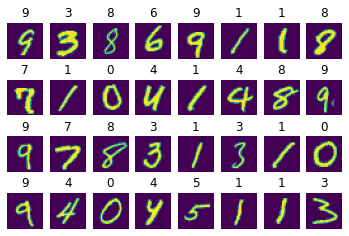

In [3]:
# Plotting the first batch of images

images, labels = iter(data_loader).next()
rows = 4
cols = 8

for i in range(len(images)):
    plt.subplot(rows, cols, i+1)
    plt.imshow(images[i].reshape(28,28))
    plt.title(int(labels[i]))
    plt.axis('off')
plt.show()

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    def get_image(self, pts):
        return self.decoder(pts)

In [5]:
# Initialising model, loss function and optimizer

model = AutoEncoder()
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-8)

In [6]:
# Training Loop

epochs = 12
print_every = 1
outputs = []
losses = []

for epoch in range(epochs):
    epoch_loss = 0
    for images, labels in data_loader:
        images = images.reshape(-1, 28*28)
        reconstructed_images = model(images)
        
        optimizer.zero_grad()
        batch_loss = loss(reconstructed_images, images)
        epoch_loss += batch_loss.item() * len(labels)
        batch_loss.backward()
        optimizer.step()
    losses.append(epoch_loss/len(data_loader))
    if epoch % print_every == 0:
        print(f'Epoch: {epoch+1}/{epochs}, Loss: {epoch_loss}')
    outputs.append((epoch, images, reconstructed_images))

Epoch: 1/12, Loss: 3044.780089020729
Epoch: 11/12, Loss: 2573.743484377861


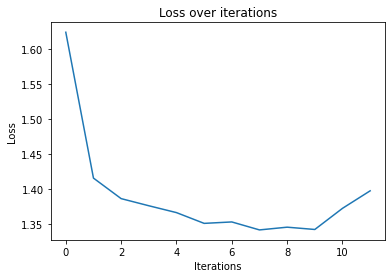

In [7]:
# Plotting the loss over time

plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.show()

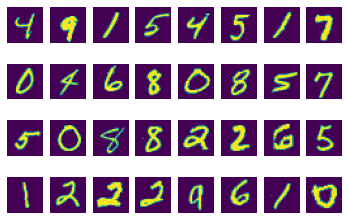

In [8]:
# Displaying output images

images = outputs[0][1]
rows = 4
cols = 8

for i in range(len(images)):
    plt.subplot(rows, cols, i+1)
    plt.imshow(images[i].reshape(28,28))
    plt.axis('off')

plt.show()

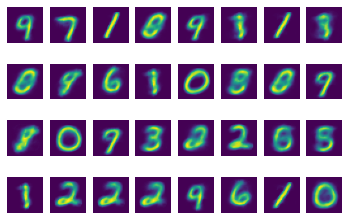

In [9]:
images = outputs[0][2].detach().numpy()
for i in range(len(images)):
    plt.subplot(rows, cols, i+1)
    plt.imshow(images[i].reshape(28,28))
    plt.axis('off')
plt.show()

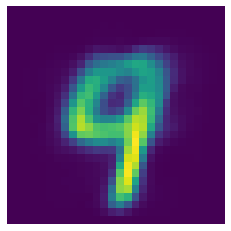

In [13]:
# Generating a photo from point 'pt'

pt = [0,0]
pt = torch.Tensor(pt)

image = model.get_image(pt).detach().numpy().reshape(28,28)
plt.imshow(image)
plt.axis('off')
plt.show()

In [12]:
# Saving the model for further use

torch.save(model.state_dict(), f'model_{losses[-1]}.pth')